In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn
%matplotlib inline

In [5]:
#load all models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')

#pickle files
mean = pickle.load(open('./model/mean_preprocess.pickle', 'rb'))
model_svm = pickle.load(open('./model/model_svm.pickle', 'rb'))
model_pca = pickle.load(open('./model/pca_50.pickle', 'rb'))

print('Models Loaded Successfully')

Models Loaded Successfully


In [6]:
gender_pre = ['Male', 'Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [7]:
#test data
test_data_path = 'testimage.jpg'
color = 'bgr'
img = cv2.imread(test_data_path)

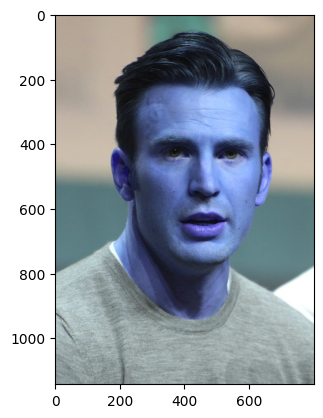

In [8]:
plt.imshow(img)

In [33]:
def pipeline_model(img, color='rgb'):
    if color == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = haar.detectMultiScale(gray, 1.5, 3)

    for x,y,w,h in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0),2)
        roi = gray[y:y+h, x:x+w]
        roi = roi/255

        if roi.shape[1] > 100:
            roi_resize =cv2.resize(roi, (100,100), cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi, (100,100), cv2.INTER_CUBIC)

        roi_reshape = roi_resize.reshape(1,10000)
        roi_mean = roi_reshape - mean
        eigen_image = model_pca.transform(roi_mean)
        results = model_svm.predict_proba(eigen_image)[0]

        predict = results.argmax()
        score = results[predict]

        text = "%s : %0.2f"%(gender_pre[predict],score)
        cv2.putText(img, text, (x,y), font,1, (0,255,0), 2)

    return img

In [27]:
eig_mg = model_pca.inverse_transform(eigen_image)

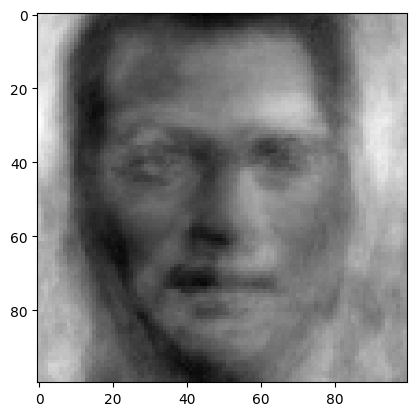

In [29]:
plt.imshow(eig_mg.reshape((100,100)), cmap='gray')

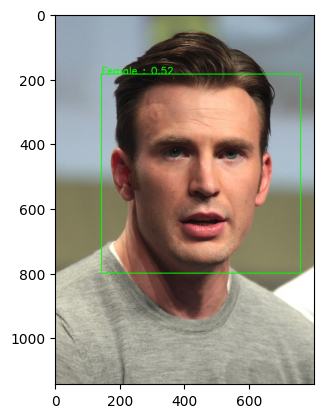

In [32]:
from PIL import Image
import matplotlib.image as mat_image

test_data_path = 'testimage.jpg'

color = 'bgr'

img = Image.open(test_data_path)
img = np.array(img)
img,_ = pipeline_model(img)
plt.imshow(img)

In [35]:
cap = cv2.VideoCapture('late-for-work.mp4')
while True:
    ret, frame = cap.read()
    if ret == False:
        break
    frame = pipeline_model(frame, color='bgr')
    cv2.imshow('Gender Detector', frame)
    if cv2.waitKey(1) == ord('s'):
        break
cv2.destroyAllWindows()
cap.release()